# Zillow Prediction 2017
## Goals:
* Construct an ML Regression model that predicts propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

* Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

* Make recommendations on what works or doesn't work in predicting these homes' values.

* Other key drivers:

## Imports

In [1]:
# necessary imports
import numpy as np
import os
import seaborn as sns
import scipy.stats as stat
from scipy.stats import pearsonr
from scipy.stats import pointbiserialr
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import warnings
warnings.filterwarnings("ignore")

import wrangle as wra
import env
import explore as exp
import evaluate as ev

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif

## Acquire
* Data is pulled from Zillow dataset tables (properties_2017, predictions_2017) joined in SQL with a function updating to CSV in case of disconnection
* Includes only single family homes ('261' code) and 2017 transactions
* Contains 52441 rows with 8 columns
* Each row is a home/property
* Each column is a home feature

## Prepare

* stripped and renamed all columns appropriately for easy recall
* All nulls in rows deleted in data except 'garagecarcnt' where nulls equals '0'
* changed some floats to integers
* target value 'taxvalue' is continuous float
* handled outliers for better distribution and visuals
* created dummie columns for the three counties

## Data Dictionary

| Features     | Definition                                                                                                           | Unit        |
|--------------|----------------------------------------------------------------------------------------------------------------------|-------------|
| taxvalue     | Assessed tax value of the home.                                                                                      | US Dollar   |
| bedroomcnt   | Number of bedrooms in home.                                                                                          |             |
| bathroomcnt  | Number of bathrooms in home including half baths.                                                                    |             |
| finished_sf  | Total of square feet in the finished home.                                                                           | Square Feet |
| garagecarcnt | Number of car spots in garage.                                                                                       |             |
| lotsize_sf   | Total of square feet for the property or lot.                                                                        | Square Feet |
| yearbuilt    | Year the home's build.                                                                                               |             |
| county       | County in which the property resides. a.k.a 'fips' 6037=Los Angeles County, 6059=Orange County,  6111=Ventura County |             |

In [2]:
# build query and look at data
zillow_query = """
        select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, garagecarcnt, lotsizesquarefeet, yearbuilt, fips
        from properties_2017
        join predictions_2017 using (parcelid)
        where propertylandusetypeid = '261'
        AND YEAR(transactiondate) = 2017;
        """

df = wra.get_zillow_data(zillow_query)

df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,garagecarcnt,lotsizesquarefeet,yearbuilt,fips
0,4.0,3.5,3100.0,1023282.0,2.0,4506.0,1998.0,6059.0
1,2.0,1.0,1465.0,464000.0,1.0,12647.0,1967.0,6111.0
2,3.0,2.0,1243.0,564778.0,2.0,8432.0,1962.0,6059.0
3,4.0,3.0,2376.0,145143.0,NaN,13038.0,1970.0,6037.0
4,4.0,3.0,2962.0,773303.0,NaN,63000.0,1950.0,6037.0


In [5]:
# see if the rows are the desired 52K
df.shape

(52441, 8)

In [3]:
#rename columns
df.rename(columns={'calculatedfinishedsquarefeet': 'finished_sf', 'taxvaluedollarcnt': 'taxvalue', 'lotsizesquarefeet': 'lotsize_sf', 'fips': 'county'}, inplace=True)

## A brief look at the data

In [4]:
df.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
0,4.0,3.5,3100.0,1023282.0,2.0,4506.0,1998.0,6059.0
1,2.0,1.0,1465.0,464000.0,1.0,12647.0,1967.0,6111.0
2,3.0,2.0,1243.0,564778.0,2.0,8432.0,1962.0,6059.0
3,4.0,3.0,2376.0,145143.0,NaN,13038.0,1970.0,6037.0
4,4.0,3.0,2962.0,773303.0,NaN,63000.0,1950.0,6037.0


In [5]:
# look at our dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedroomcnt    52441 non-null  float64
 1   bathroomcnt   52441 non-null  float64
 2   finished_sf   52359 non-null  float64
 3   taxvalue      52440 non-null  float64
 4   garagecarcnt  18015 non-null  float64
 5   lotsize_sf    52072 non-null  float64
 6   yearbuilt     52325 non-null  float64
 7   county        52441 non-null  float64
dtypes: float64(8)
memory usage: 3.2 MB


## A summary of the data

In [6]:
# change all NaNs to '0' in 'garagecarcnt' column
df['garagecarcnt'] = df['garagecarcnt'].fillna(0)

In [7]:
df.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
0,4.0,3.5,3100.0,1023282.0,2.0,4506.0,1998.0,6059.0
1,2.0,1.0,1465.0,464000.0,1.0,12647.0,1967.0,6111.0
2,3.0,2.0,1243.0,564778.0,2.0,8432.0,1962.0,6059.0
3,4.0,3.0,2376.0,145143.0,0.0,13038.0,1970.0,6037.0
4,4.0,3.0,2962.0,773303.0,0.0,63000.0,1950.0,6037.0


In [8]:
# drop all null rows
df.dropna(inplace=True)

In [9]:
# see how many rows we lost (452)
df.shape

(51959, 8)

In [15]:
#verify if any nulls in columns
df.isnull().sum()

bedroomcnt      0
bathroomcnt     0
finished_sf     0
taxvalue        0
garagecarcnt    0
lotsize_sf      0
yearbuilt       0
county          0
dtype: int64

In [17]:
# change some floats to integers for brevity
df[['bedroomcnt', 'finished_sf', 'taxvalue', 'garagecarcnt', 'lotsize_sf', 'yearbuilt', 'county']] = df[['bedroomcnt', 'finished_sf', 'taxvalue', 'garagecarcnt', 'lotsize_sf', 'yearbuilt', 'county']].astype(int)

In [18]:
# verify Dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51959 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedroomcnt    51959 non-null  int64  
 1   bathroomcnt   51959 non-null  float64
 2   finished_sf   51959 non-null  int64  
 3   taxvalue      51959 non-null  int64  
 4   garagecarcnt  51959 non-null  int64  
 5   lotsize_sf    51959 non-null  int64  
 6   yearbuilt     51959 non-null  int64  
 7   county        51959 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 3.6 MB


In [19]:
df.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
0,4,3.5,3100,1023282,2,4506,1998,6059
1,2,1.0,1465,464000,1,12647,1967,6111
2,3,2.0,1243,564778,2,8432,1962,6059
3,4,3.0,2376,145143,0,13038,1970,6037
4,4,3.0,2962,773303,0,63000,1950,6037


In [20]:
# change 'fips' codes to names of 'county'
df.county = df.county.map({6037:'LA',6059:'Orange',6111:'Ventura'})

In [21]:
df.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
0,4,3.5,3100,1023282,2,4506,1998,Orange
1,2,1.0,1465,464000,1,12647,1967,Ventura
2,3,2.0,1243,564778,2,8432,1962,Orange
3,4,3.0,2376,145143,0,13038,1970,LA
4,4,3.0,2962,773303,0,63000,1950,LA


In [31]:
# shrinking outliers
df = df [df.finished_sf < 25_000]
df = df[df.lotsize_sf < 76_000]
df = df [df.taxvalue < df.taxvalue.quantile(.95)].copy()
df = df[df.taxvalue > df.taxvalue.quantile(.001)].copy()

In [41]:
df.shape

(44098, 8)

In [32]:
# checking max parameters
for col in df.columns:
    top_5 = df[col].nlargest(5)
    print(f'Top 5 largest values in column {col}:')
    print(top_5)

Top 5 largest values in column bedroomcnt:
21981    11
33311    10
6631      9
7765      9
13676     9
Name: bedroomcnt, dtype: int64
Top 5 largest values in column bathroomcnt:
33311    10.0
27996     9.0
32002     8.0
47038     8.0
36840     7.5
Name: bathroomcnt, dtype: float64
Top 5 largest values in column finished_sf:
7765     7970
32002    7942
9795     7524
49872    6868
30722    6756
Name: finished_sf, dtype: int64
Top 5 largest values in column taxvalue:
43650    837688
23865    837622
44458    837618
3808     837581
14927    837581
Name: taxvalue, dtype: int64
Top 5 largest values in column garagecarcnt:
26594    9
28454    8
4400     7
18089    7
33437    7
Name: garagecarcnt, dtype: int64
Top 5 largest values in column lotsize_sf:
19789    74922
5839     74805
16856    74764
12545    74664
39960    74430
Name: lotsize_sf, dtype: int64
Top 5 largest values in column yearbuilt:
39822    2016
1336     2015
5795     2015
7316     2015
7910     2015
Name: yearbuilt, dtype: int6

TypeError: Cannot use method 'nlargest' with dtype object

In [33]:
# checking min parameters
for col in df.columns:
    bottom_5 = df[col].nsmallest(5)
    print(f'Bottom 5 smallest values in column {col}:')
    print(bottom_5)

Bottom 5 smallest values in column bedroomcnt:
2694    0
3261    0
4675    0
6132    0
6343    0
Name: bedroomcnt, dtype: int64
Bottom 5 smallest values in column bathroomcnt:
2694     0.0
6132     0.0
10294    0.0
10970    0.0
14279    0.0
Name: bathroomcnt, dtype: float64
Bottom 5 smallest values in column finished_sf:
6132     128
51075    152
39656    240
3261     288
23504    300
Name: finished_sf, dtype: int64
Bottom 5 smallest values in column taxvalue:
17346    25836
1544     25837
14796    25875
23367    26038
35734    26038
Name: taxvalue, dtype: int64
Bottom 5 smallest values in column garagecarcnt:
3    0
4    0
5    0
6    0
7    0
Name: garagecarcnt, dtype: int64
Bottom 5 smallest values in column lotsize_sf:
45424    236
4509     480
3386     540
3841     540
19685    540
Name: lotsize_sf, dtype: int64
Bottom 5 smallest values in column yearbuilt:
27586    1878
41189    1880
38763    1882
1147     1885
3950     1885
Name: yearbuilt, dtype: int64


TypeError: Cannot use method 'nsmallest' with dtype object

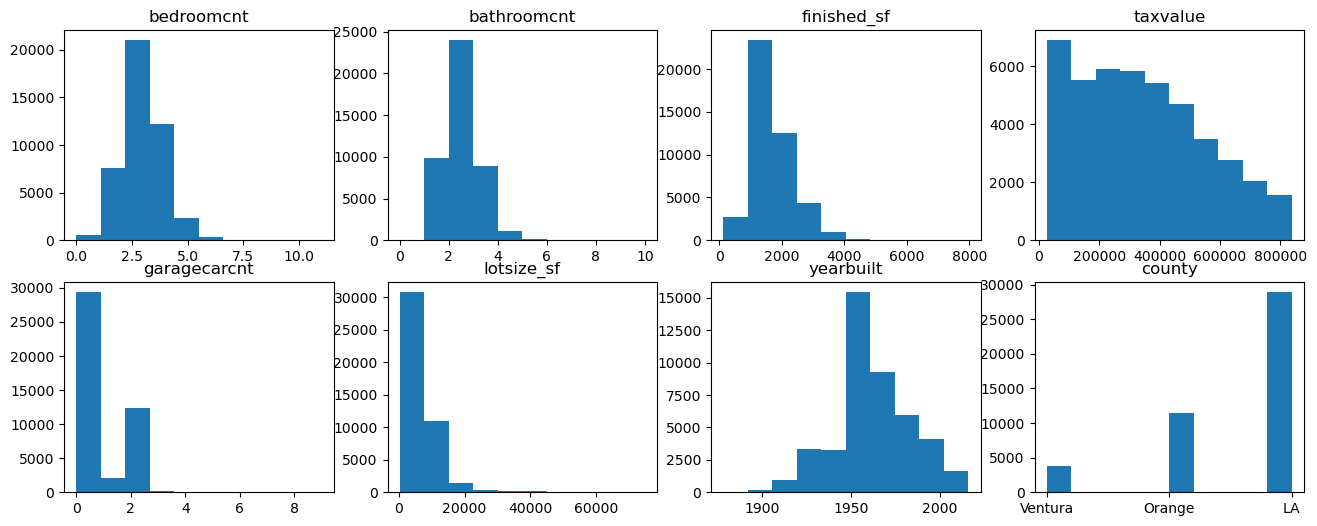

In [34]:
plt.figure(figsize=(16, 6))

for i, col in enumerate(df.columns):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(2, 4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    plt.hist(df[col])

plt.show()

bedroomcnt


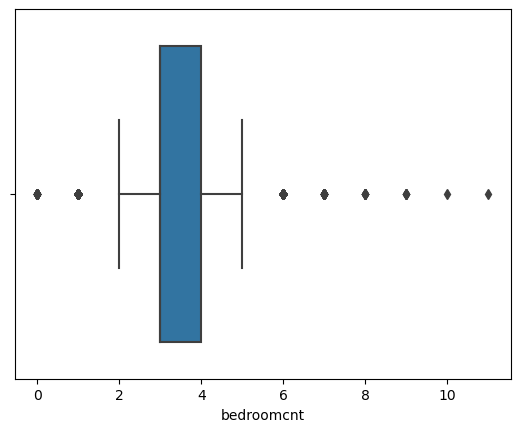

0        43
1       487
2      7621
3     21005
4     12208
5      2360
6       316
7        43
8         8
9         5
10        1
11        1
Name: bedroomcnt, dtype: int64

bathroomcnt


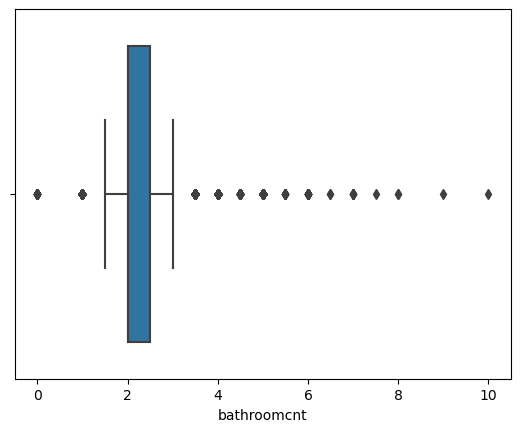

0.0        29
1.0      9034
1.5       820
2.0     20465
2.5      3508
3.0      8507
3.5       376
4.0      1023
4.5       102
5.0       181
5.5         9
6.0        30
6.5         2
7.0         7
7.5         1
8.0         2
9.0         1
10.0        1
Name: bathroomcnt, dtype: int64

finished_sf


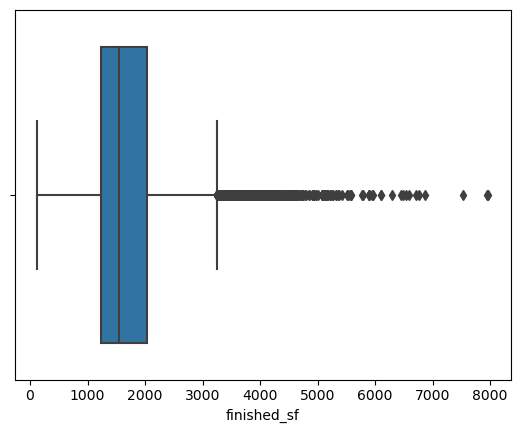

128     1
152     1
240     1
288     1
300     1
       ..
6756    1
6868    1
7524    1
7942    1
7970    1
Name: finished_sf, Length: 3372, dtype: int64

taxvalue


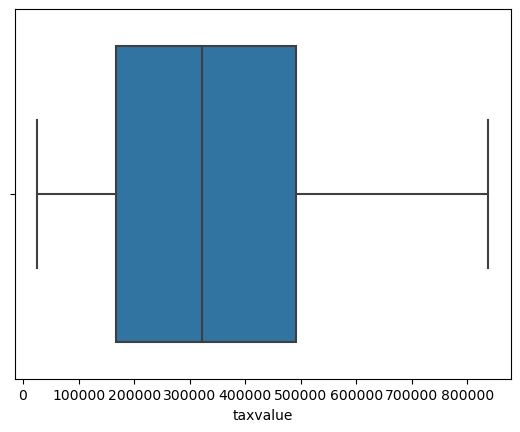

25836     1
25837     1
25875     1
26038     2
26040     1
         ..
837580    1
837581    3
837618    1
837622    1
837688    1
Name: taxvalue, Length: 32245, dtype: int64

garagecarcnt


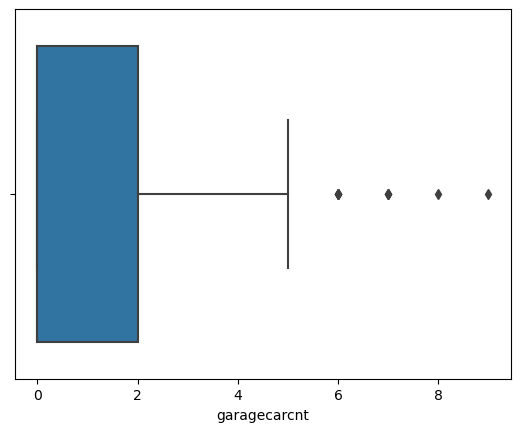

0    29341
1     2025
2    12417
3      239
4       59
5        8
6        4
7        3
8        1
9        1
Name: garagecarcnt, dtype: int64

lotsize_sf


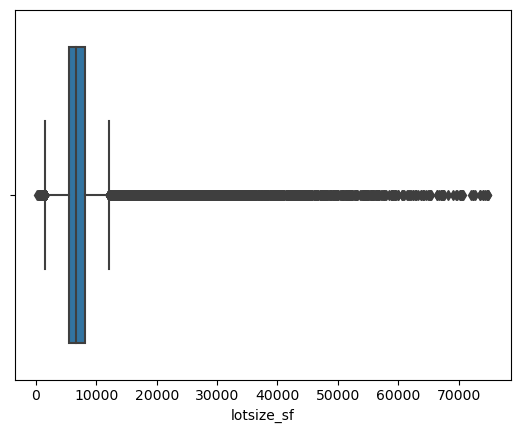

236      1
480      1
540      8
592      1
594      1
        ..
74430    1
74664    1
74764    1
74805    1
74922    1
Name: lotsize_sf, Length: 11697, dtype: int64

yearbuilt


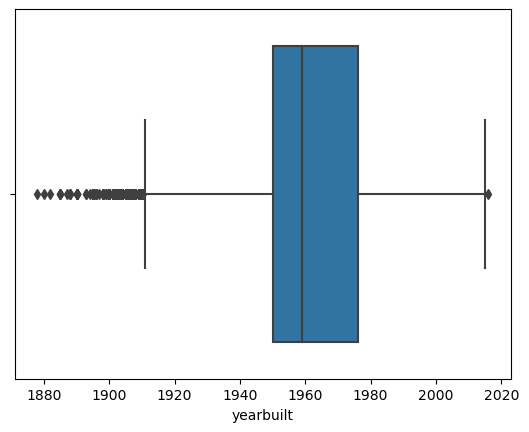

1878       1
1880       1
1882       1
1885       4
1887       1
1888       3
1890       7
1893       2
1894       1
1895      10
1896       5
1897       1
1898       6
1899       3
1900       9
1901      13
1902      10
1903      16
1904      17
1905      56
1906      48
1907      37
1908      53
1909      59
1910     109
1911      86
1912     116
1913      89
1914      69
1915      71
1916      34
1917      40
1918      45
1919      61
1920     154
1921     175
1922     330
1923     447
1924     420
1925     391
1926     332
1927     277
1928     265
1929     210
1930     149
1931      95
1932      68
1933      42
1934      44
1935      93
1936     177
1937     208
1938     300
1939     357
1940     439
1941     440
1942     292
1943     144
1944     288
1945     147
1946     340
1947     888
1948     813
1949     866
1950    1492
1951    1047
1952    1089
1953    1374
1954    1425
1955    1800
1956    1261
1957     914
1958     713
1959     955
1960     790
1961     744
1962     911

In [36]:
for col in df.columns[:-1]:
    print(col)
    sns.boxplot(data=df, x=col)
    plt.show()
    
    print(df[col].value_counts().sort_index())
    print()

In [37]:
train, validate, test = wra.split_data(df)

In [42]:
print (f'''{train.shape}
{validate.shape}
{test.shape}''')

(26458, 8)
(8820, 8)
(8820, 8)


## Scale Data

In [43]:
to_scale = ['bedroomcnt', 'bathroomcnt', 'finished_sf', 'garagecarcnt', 'lotsize_sf', 'yearbuilt']

In [44]:
exp.scale_data(train, validate, test, to_scale)

(       bedroomcnt  bathroomcnt  finished_sf  taxvalue  garagecarcnt  \
 28498    0.272727         0.20     0.130663    306867      0.000000   
 33158    0.272727         0.10     0.117993     43277      0.000000   
 12088    0.363636         0.35     0.409393    828516      0.333333   
 900      0.272727         0.20     0.121833    367613      0.000000   
 44834    0.181818         0.10     0.129511    410000      0.111111   
 ...           ...          ...          ...       ...           ...   
 30576    0.272727         0.15     0.126952    189649      0.111111   
 23510    0.363636         0.30     0.294599    790000      0.000000   
 18845    0.272727         0.20     0.163297    436897      0.111111   
 42760    0.272727         0.20     0.139237    163848      0.000000   
 38659    0.272727         0.30     0.343742    650609      0.222222   
 
        lotsize_sf  yearbuilt   county  
 28498    0.074847   0.613139       LA  
 33158    0.062738   0.474453       LA  
 12088    0

In [46]:
train_scaled, validate_scaled, test_scaled = exp.scale_data(train, validate, test, to_scale)

In [47]:
train_scaled.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
28498,0.272727,0.20,0.130663,306867,0.000000,0.074847,0.613139,LA
33158,0.272727,0.10,0.117993,43277,0.000000,0.062738,0.474453,LA
12088,0.363636,0.35,0.409393,828516,0.333333,0.275991,0.905109,Ventura
900,0.272727,0.20,0.121833,367613,0.000000,0.076139,0.605839,LA
44834,0.181818,0.10,0.129511,410000,0.111111,0.084359,0.364964,Orange


In [48]:
exp.plot_variable_pairs(df)

ValueError: Cannot take a larger sample than population when 'replace=False'